This is the banchmarking of the network architecture 

In [1]:

import sys
sys.path.append('../../..')

import os
os.environ['PYTHONPATH'] = '../../..'

In [2]:
import mysql.connector
import pandas as pd
from sqlalchemy import create_engine,text

# Torch imports
import torch
import torch.nn as nn
import torch.optim as optim

## MedFL Imports 
## Network Manager Imports 
from Medfl.NetManager.node import Node
from Medfl.NetManager.network import Network
from Medfl.NetManager.dataset import DataSet
from Medfl.NetManager.flsetup import FLsetup

# flower imports 
import flwr as fl

## Learning Manager imports 
from Medfl.LearningManager.dynamicModal import DynamicModel
from Medfl.LearningManager.model import Model
from Medfl.LearningManager.strategy import Strategy
from Medfl.LearningManager.server import *
from Medfl.LearningManager.flpipeline import *
from Medfl.LearningManager.plot import AccuracyLossPlotter



# Utils
from Medfl.LearningManager.utils import *


C:\Users\HP User\AppData\Local\Temp\ipykernel_25256\3319853876.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-21 01:41:15,021	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
# DB Creation 
!python ../../../scripts/create_db.py

# clearn DB 
# empty_db()

d:\ESI\3CS\PFE\last_year\Code\MEDfl\scripts\create_db.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
# Create a nest work "Net_1"
Net_1 = Network(name="manual_network_2")
Net_1.create_network()

Net_1.name

'manual_network_2'

In [5]:
# Create a MasterDataSet from Net_1
Net_1.create_master_dataset()

# Check if the Network has a masterDataSet Table ( 1: Table exists ; 0: Table doesn't exist)
Net_1.mtable_exists

D:\ESI\3CS\PFE\last_year\Code\MEDfl/notebooks/data/masterDataSet/Mimic_ouael.csv


1

In [6]:
# auto FLsetup creation
autoFl  = FLsetup(name = "Flsetup_2", description = "The second fl setup",network = Net_1)
autoFl.create()

# List all setups 
FLsetup.list_allsetups()

,FLsetupId,name,description,creation_date,NetId,column_name
0,1,Flsetup_2,The second fl setup,2024-03-21 01:41:36,1,None


# Configuration_1: A Manual network with 50 Nodes 
This network contains 50 nodes (40 Train nodes and 10 test nodes)

In [7]:
# Create 40 train nodes
for i in range(1,6):
    hospital = Node(name="hospital_"+str(i) , train=1)
    Net_1.add_node(hospital)
    hospital.upload_dataset("hospital_"+str(i)+'_dataset' , global_params['base_url']+ '/notebooks/data/nodesData/output_'+str(i)+'.csv')


In [8]:
# Create 10 test nodes
for i in range(6,11):
    hospital = Node(name="hospital_"+str(40+i) , train=0)
    Net_1.add_node(hospital)
    hospital.upload_dataset("hospital_"+str(40+i)+'_dataset' , global_params['base_url']+ '/notebooks/data/nodesData/output_'+str(i)+'.csv')

In [9]:
# List all created nodes on the db 
Node.list_allnodes()

,NodeId,NodeName,train,NetId
0,1,hospital_1,1,1
1,2,hospital_2,1,1
2,3,hospital_3,1,1
3,4,hospital_4,1,1
4,5,hospital_5,1,1
5,6,hospital_46,0,1
6,7,hospital_47,0,1
7,8,hospital_48,0,1
8,9,hospital_49,0,1
9,10,hospital_50,0,1


In [10]:
# Create FLDataSet
fl_dataset = autoFl.create_federated_dataset(
    output="deceased", 
    fit_encode=[], 
    to_drop=[ "deceased" ]
    )

In [11]:
fl_dataset.size

17

In [12]:
# Creating a DynamicModel instance
dynamic_model = DynamicModel()

# Creating a specific model dynamically using DynamicModel
specific_model = dynamic_model.create_model(model_type='Logistic Regressor', params_dict={"input_dim": 17, "output_dim": 1})

# Pass the specific_model to the Model class
optimizer = optim.SGD(specific_model.parameters(), lr=0.0001)
criterion = nn.BCELoss()


# Creating a new Model instance using the specific model created by DynamicModel
global_model = Model(specific_model, optimizer, criterion)

# The modal to be passed to the server
global_model.get_parameters()

[array([[-0.19287744, -0.15479593, -0.07340494,  0.17492747,  0.0746356 ,
          0.0290359 , -0.17152557, -0.15779404, -0.12523171,  0.14842144,
          0.20322552,  0.08128414,  0.2372028 , -0.01805884,  0.10851038,
          0.20537335,  0.03058577]], dtype=float32),
 array([0.21642819], dtype=float32)]

In [13]:
# Define the neural network model using PyTorch
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.3)
        self.output = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x

In [14]:
# Load the pretrained model
model = Model.load_model("../../../notebooks/.ipynb_checkpoints/trainedModels/grid_search_classifier.pth")


# Pass the specific_model to the Model class
optimizer = optim.SGD(model.parameters(), lr=0.0001)
# Define loss function and optimizer
pos_weight = torch.tensor([7 ])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Creating a new Model instance using the specific model created by DynamicModel
global_model = Model(model, optimizer, criterion)

# Get the initial params of the model 
init_params = global_model.get_parameters() ; 

print(model)

Sequential(
  (0): Linear(in_features=17, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=1, bias=True)
  (3): Sigmoid()
)


In [15]:
# Create the strategy
fed_avg = Strategy("FedAvg", 
                   fraction_fit = 1.0 ,
                   fraction_evaluate = 1.0,
                   min_fit_clients = 2,
                   min_evaluate_clients = 2,
                   min_available_clients = 2 , 
                   initial_parameters=global_model.get_parameters())

In [16]:
fed_avg.create_strategy() ; 

In [17]:
# Create The server 
server = FlowerServer(global_model, strategy = fed_avg, num_rounds = 10,
                       num_clients  = len(fl_dataset.trainloaders), 
                       fed_dataset = fl_dataset,diff_privacy = True ,
                       # You can change the resources alocated for each client based on your machine 
                       client_resources={'num_cpus': 1.0, 'num_gpus': 0.0}
                       )

In [18]:
# Create the pipeline 
ppl_1 = FLpipeline( name ="the second fl_pipeline",description = "this is our first FL pipeline",
                   server = server)

In [19]:
# Run the Traning of the model
history = ppl_1.server.run()

INFO flwr 2024-03-21 01:41:54,700 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
03/21/2024 01:41:54:INFO:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2024-03-21 01:42:01,161	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-21 01:42:06,244 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 248985600.0, 'object_store_memory': 78643200.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0, 'node:__internal_head__': 1.0}
03/21/2024 01:42:06:INFO:Flower VCE: Ray initialized with resources: {'memory': 248985600.0, 'object_store_memory': 78643200.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0, 'node:__internal_head__': 1.0}
INFO flwr 2024-03-21 01:42:06,247 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
03/21/2024 01:42:06:INFO:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simu


 __________________________________ 

102


(DefaultActor pid=2904) d:\ESI\3CS\PFE\last_year\Code\MEDfl\Medfl\LearningManager\utils.py:13: DeprecationWarning: 
(DefaultActor pid=2904) Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(DefaultActor pid=2904) (to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
(DefaultActor pid=2904) but was not found to be installed on your system.
(DefaultActor pid=2904) If this would cause problems for you,
(DefaultActor pid=2904) please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
(DefaultActor pid=2904)         
(DefaultActor pid=2904)   import pandas as pd
(DefaultActor pid=2904) d:\ESI\3CS\PFE\last_year\Code\MEDfl\Medfl\LearningManager\utils.py:19: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
(DefaultActor pid=2904)   global_yaml_path = pkg_resources.resource_filen

(DefaultActor pid=17772) 
(DefaultActor pid=17772)  -------------------------------- 
(DefaultActor pid=17772)   this is the config of the client
(DefaultActor pid=17772) [Client 1] fit, config: {}
(DefaultActor pid=17772) 
(DefaultActor pid=17772)  -------------------------------- 
(DefaultActor pid=17772)   
(DefaultActor pid=17772) 	Train Epoch: 0 	Loss: 1.554100 Acc@1: 32.625992 (ε = 0.28, δ = 1e-5)
(DefaultActor pid=23644)    [repeated 12x across cluster]
(DefaultActor pid=23644)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=23644)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=23644) [Client 0] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=17772) 	Train Epoch: 1 	Loss: 1.775304 Acc@1: 17.592593 (ε = 0.50, δ = 1e-5) [repeated 10x across cluster]
(DefaultActor pid=17772) 	Train Epoch: 2 	Loss: 1.308107 Acc@1: 28.433455 (ε = 0.64, δ = 1e-5) [repeated 10x across cluster]
(DefaultActor pid=17772) 	

DEBUG flwr 2024-03-21 02:47:37,608 | server.py:236 | fit_round 1 received 5 results and 0 failures
03/21/2024 02:47:37:DEBUG:fit_round 1 received 5 results and 0 failures


(DefaultActor pid=23644) epsilon of client 0 : eps = 4.99301167796232 [repeated 2x across cluster]


WARNING flwr 2024-03-21 02:47:37,716 | fedavg.py:250 | No fit_metrics_aggregation_fn provided
03/21/2024 02:47:37:WARNING:No fit_metrics_aggregation_fn provided
c:\Python39\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python39\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
INFO flwr 2024-03-21 02:47:38,037 | server.py:125 | fit progress: (1, 0.05818698920455633, {'accuracy': 0.8098958333333334}, 3931.2737841)
03/21/2024 02:47:38:INFO:fit progress: (1, 0.05818698920455633, {'accuracy': 0.8098958333333334}, 3931.2737841)
DEBUG flwr 2024-03-21 02:47:38,052 | server.py:173 | evaluate_round 1: strategy sampled 5 clients (out of 5)
03/21/2024 02:47:38:DEBUG:evaluate_round 1: strategy sampled 5 clients (out of 5)



 __________________________________ 

102
(DefaultActor pid=12584) [Client 3] evaluate, config: {}


(DefaultActor pid=12584) c:\Python39\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
(DefaultActor pid=12584)   return _methods._mean(a, axis=axis, dtype=dtype,
(DefaultActor pid=12584) c:\Python39\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
(DefaultActor pid=12584)   ret = ret.dtype.type(ret / rcount)
(DefaultActor pid=23644) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 4x across cluster]
(DefaultActor pid=23644)   client = check_clientfn_returns_client(client_fn(cid)) [repeated 4x across cluster]
(

(DefaultActor pid=12584) 
(DefaultActor pid=12584)  __________________________________ 
(DefaultActor pid=12584) 
(DefaultActor pid=12584) 102


DEBUG flwr 2024-03-21 02:48:02,063 | server.py:187 | evaluate_round 1 received 5 results and 0 failures
03/21/2024 02:48:02:DEBUG:evaluate_round 1 received 5 results and 0 failures
WARNING flwr 2024-03-21 02:48:02,071 | fedavg.py:281 | No evaluate_metrics_aggregation_fn provided
03/21/2024 02:48:02:WARNING:No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2024-03-21 02:48:02,075 | server.py:222 | fit_round 2: strategy sampled 5 clients (out of 5)
03/21/2024 02:48:02:DEBUG:fit_round 2: strategy sampled 5 clients (out of 5)
(DefaultActor pid=2904) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
(DefaultActor pid=2904)   warnings.warn(
(DefaultActor pid=2904) C:\Users\HP User\AppData\Roaming\Python\Python39\sit

(DefaultActor pid=2904)  -------------------------------- 
(DefaultActor pid=2904)   this is the config of the client
(DefaultActor pid=2904) [Client 3] fit, config: {}
(DefaultActor pid=2904)  -------------------------------- 
(DefaultActor pid=23644) [Client 0] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=2904)    [repeated 15x across cluster]
(DefaultActor pid=23644)  __________________________________  [repeated 4x across cluster]


(DefaultActor pid=12584) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower.
(DefaultActor pid=12584)   client = check_clientfn_returns_client(client_fn(cid))
(DefaultActor pid=12584) c:\Python39\lib\site-packages\torch\nn\modules\module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
(DefaultActor pid=12584)   warnings.warn("Using a non-full backward hook when the forward contains multiple autog

(DefaultActor pid=2904) 	Train Epoch: 0 	Loss: 1.447326 Acc@1: 41.837986 (ε = 0.28, δ = 1e-5)
(DefaultActor pid=17772)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=17772)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=17772) [Client 2] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=17772)    [repeated 12x across cluster]
(DefaultActor pid=2904) 	Train Epoch: 1 	Loss: 1.503633 Acc@1: 33.722291 (ε = 0.50, δ = 1e-5) [repeated 10x across cluster]
(DefaultActor pid=2904) 	Train Epoch: 2 	Loss: 1.404358 Acc@1: 24.966330 (ε = 0.64, δ = 1e-5) [repeated 10x across cluster]
(DefaultActor pid=12584) 	Train Epoch: 3 	Loss: 1.410271 Acc@1: 40.514559 (ε = 0.76, δ = 1e-5) [repeated 10x across cluster]
(DefaultActor pid=12584) 	Train Epoch: 4 	Loss: 1.474355 Acc@1: 42.652830 (ε = 0.87, δ = 1e-5) [repeated 10x across cluster]
(DefaultActor pid=2904) 	Train Epoch: 5 	Loss: 1.606042 Acc@1: 44.439834 (ε = 0.96, δ = 1e-

DEBUG flwr 2024-03-21 03:40:12,325 | server.py:236 | fit_round 2 received 5 results and 0 failures
03/21/2024 03:40:12:DEBUG:fit_round 2 received 5 results and 0 failures
c:\Python39\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python39\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
INFO flwr 2024-03-21 03:40:12,714 | server.py:125 | fit progress: (2, 0.05818698920455633, {'accuracy': 0.8098958333333334}, 7085.950510799999)
03/21/2024 03:40:12:INFO:fit progress: (2, 0.05818698920455633, {'accuracy': 0.8098958333333334}, 7085.950510799999)
DEBUG flwr 2024-03-21 03:40:12,731 | server.py:173 | evaluate_round 2: strategy sampled 5 clients (out of 5)
03/21/2024 03:40:12:DEBUG:evaluate_round 2: strategy sampled 5 clients (out of 5)



 __________________________________ 

102


(DefaultActor pid=23644) c:\Python39\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
(DefaultActor pid=23644)   return _methods._mean(a, axis=axis, dtype=dtype,
(DefaultActor pid=23644) c:\Python39\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
(DefaultActor pid=23644)   ret = ret.dtype.type(ret / rcount)
(DefaultActor pid=17772) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower. [repeated 3x across cluster]
(DefaultActor pid=17772)   client = check_clientfn_returns_client(client_fn(cid)) [repeated 3x across cluster]
(

(DefaultActor pid=23644) [Client 4] evaluate, config: {}
(DefaultActor pid=23644) 
(DefaultActor pid=23644)  __________________________________ 
(DefaultActor pid=23644) 
(DefaultActor pid=23644) 102
(DefaultActor pid=2904) epsilon of client 3 : eps = 4.99301167796232


(DefaultActor pid=17772) c:\Python39\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
(DefaultActor pid=17772)   return _methods._mean(a, axis=axis, dtype=dtype,
(DefaultActor pid=17772) c:\Python39\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
(DefaultActor pid=17772)   ret = ret.dtype.type(ret / rcount)
DEBUG flwr 2024-03-21 03:40:32,574 | server.py:187 | evaluate_round 2 received 5 results and 0 failures
03/21/2024 03:40:32:DEBUG:evaluate_round 2 received 5 results and 0 failures
DEBUG flwr 2024-03-21 03:40:32,577 | server.py:222 | fit_round 3: strategy sampled 5 clients (out of 5)
03/21/2024 03:40:32:DEBUG:fit_round 3: strategy sampled 5 clients (out of 5)
(DefaultActor pid=2904) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\opacus\privacy_engine.py:142: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training 

(DefaultActor pid=2904)  -------------------------------- 
(DefaultActor pid=2904)   this is the config of the client
(DefaultActor pid=2904) [Client 4] fit, config: {}
(DefaultActor pid=2904)  -------------------------------- 
(DefaultActor pid=12584) [Client 2] evaluate, config: {} [repeated 4x across cluster]
(DefaultActor pid=2904)    [repeated 15x across cluster]
(DefaultActor pid=12584)  __________________________________  [repeated 4x across cluster]


(DefaultActor pid=23644) C:\Users\HP User\AppData\Roaming\Python\Python39\site-packages\flwr\simulation\ray_transport\ray_actor.py:72: DeprecationWarning:  Ensure your client is of type `flwr.client.Client`. Please convert it using the `.to_client()` method before returning it in the `client_fn` you pass to `start_simulation`. We have applied this conversion on your behalf. Not returning a `Client` might trigger an error in future versions of Flower.
(DefaultActor pid=23644)   client = check_clientfn_returns_client(client_fn(cid))
(DefaultActor pid=23644) c:\Python39\lib\site-packages\torch\nn\modules\module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
(DefaultActor pid=23644)   warnings.warn("Using a non-full backward hook when the forward contains multiple autog

(DefaultActor pid=2904) 	Train Epoch: 0 	Loss: 1.263590 Acc@1: 53.307220 (ε = 0.28, δ = 1e-5)
(DefaultActor pid=12584)  --------------------------------  [repeated 8x across cluster]
(DefaultActor pid=12584)   this is the config of the client [repeated 4x across cluster]
(DefaultActor pid=12584) [Client 2] fit, config: {} [repeated 4x across cluster]
(DefaultActor pid=12584)    [repeated 12x across cluster]
(DefaultActor pid=23644) 	Train Epoch: 1 	Loss: 1.385027 Acc@1: 42.757722 (ε = 0.50, δ = 1e-5) [repeated 11x across cluster]
(DefaultActor pid=23644) 	Train Epoch: 2 	Loss: 1.476135 Acc@1: 41.330681 (ε = 0.64, δ = 1e-5) [repeated 10x across cluster]
(DefaultActor pid=23644) 	Train Epoch: 3 	Loss: 1.371406 Acc@1: 34.183135 (ε = 0.76, δ = 1e-5) [repeated 10x across cluster]
(DefaultActor pid=23644) 	Train Epoch: 4 	Loss: 1.403969 Acc@1: 25.053763 (ε = 0.87, δ = 1e-5) [repeated 10x across cluster]
(DefaultActor pid=2904) 	Train Epoch: 5 	Loss: 1.248496 Acc@1: 61.014290 (ε = 0.96, δ = 1

(DefaultActor pid=2904) 	Train Epoch: 37 	Loss: 1.453618 Acc@1: 48.805051 (ε = 2.67, δ = 1e-5) [repeated 5x across cluster]


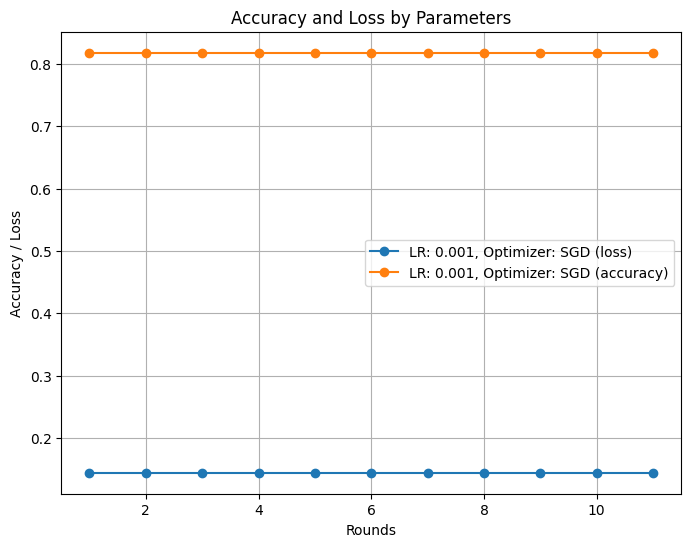

In [ ]:
# Make some plots 
global_accuracy,global_loss = ppl_1.server.accuracies,ppl_1.server.losses
results_dict = {
    ('LR: 0.001, Optimizer: SGD', 'accuracy'): global_accuracy,
    ('LR: 0.001, Optimizer: SGD', 'loss'): global_loss
}
plotter = AccuracyLossPlotter(results_dict)

plotter.plot_accuracy_loss()

In [ ]:
# Test the Modal on the Test nodes and store the results on the DB
ppl_1.auto_test()

[{'node_name': 'hospital_1',
  'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 5, 'TN': 22}, 'Accuracy': 0.815, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.815, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0}"},
 {'node_name': 'hospital_2',
  'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 2, 'TN': 25}, 'Accuracy': 0.926, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.926, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0}"},
 {'node_name': 'hospital_3',
  'classification_report': "{'confusion matrix': {'TP': 0, 'FP': 0, 'FN': 4, 'TN': 23}, 'Accuracy': 0.852, 'Sensitivity/Recall': 0.0, 'Specificity': 1.0, 'PPV/Precision': 0.0, 'NPV': 0.852, 'F1-score': 0.0, 'False positive rate': 0.0, 'True positive rate': 0.0}"},
 {'node_name': 'hospital_4',
  'classification_report': "{'confusion matrix': {'TP': 2, 'FP': 0, 'FN': 8, 'TN': 17}, '

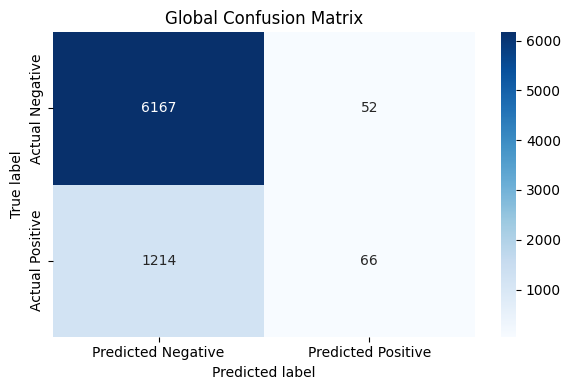

In [ ]:
# Plot the Global confusion Matrix of the pipiline "the first fl_pipeline"
AccuracyLossPlotter.plot_global_confusion_matrix(pipeline_name="the second fl_pipeline")

/home/local/USHERBROOKE/saho6810/MEDfl/code/MEDfl/Medfl/LearningManager/plot.py:226: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


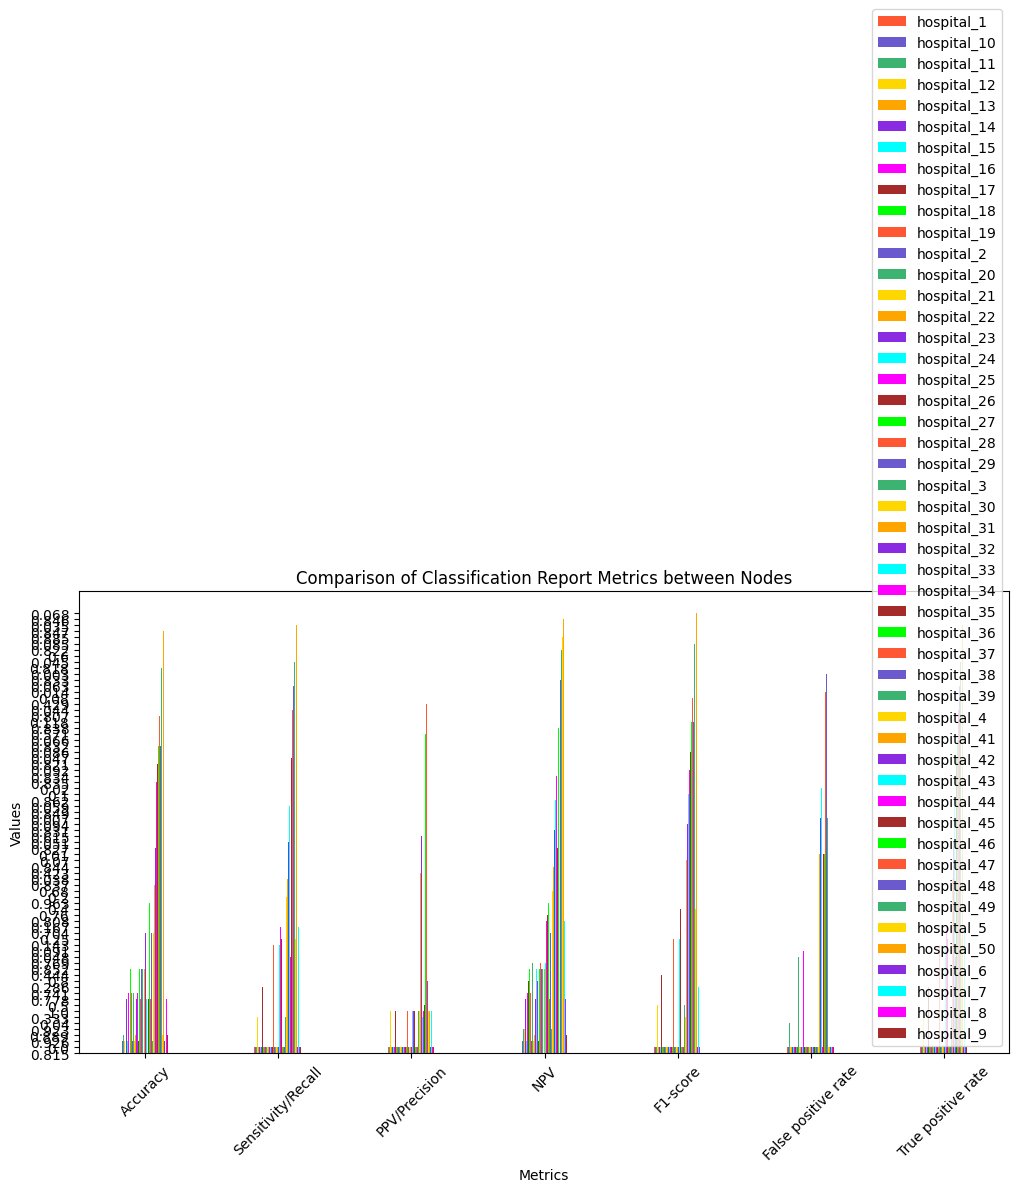

In [ ]:
AccuracyLossPlotter.plot_classification_report(pipeline_name="the first fl_pipeline")